In [1]:
from header import *
plt.rcParams.update({'font.size': 14})

In [2]:
df_seeds = read_astarix_performance('results/ecoli_illumina250_astar-seeds.tsv')
df_base = read_astarix_performance('results/ecoli_illumina250_astar-prefix.tsv')

df_seeds = read_astarix_performance('results/MHC1-astarix-prefix/alignments.tsv')
df_base = read_astarix_performance('results/MHC1-astarix-seeds/alignments.tsv')

display(df_seeds.head())

,ref,refsize,algo,operation,memory,len,read,spell,cost,starts,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states
readname,,,,,,,,,,,,,,,,,,
simulated.81,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,ATCACATCCAAATCTCACAGGCCTCAAAAGCTACAGCTGACATTCC...,0,-1,1.42,0.15,0.0,0.020333,0.000959,1,1.57,142.0
simulated.82,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,AGAAAAGTACCTCAAAAGGACAAATCTAAGAATGATTGGTGCTCAA...,0,-1,1.51,0.16,0.0,0.020695,0.017829,1,1.67,151.0
simulated.83,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,ATGAGAACACATGGACACAGGAAGGGGAACATCACACTCTGGGGAC...,0,-1,4.41,0.54,0.0,0.079559,0.002115,1,4.95,441.0
simulated.84,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,TAAAGAAATGTGACTCAGTGGTCCACATGGTTGCAGTACCTCCCAT...,0,-1,2.74,0.23,0.0,0.040670,0.001997,1,2.97,274.0
simulated.85,graphs/pasgal-MHC1.gfa,11611462,astar-prefix,align,0.0,100,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,CATTACTCAGGACAACAGAAGAGAAAGAGCAGGTCTAGAGTGTATA...,0,-1,1.30,0.15,0.0,0.020289,0.000950,1,1.45,130.0


In [3]:
def cross_validation(seeds, base):
    correct = True
    for index, row in df_seeds.iterrows():
        #display(row)
        a = df_base[df_base['read'] == row['read']]
        assert(len(a) == 1)
        r = a.iloc[0]
        if row.cost != r.cost:
            print("Mismatching costs: ", row.cost, " != ", r.cost)
            print(row)
            print(r)
            correct = False
    print('Checked ' + str(len(df_seeds)) + ' alignments.')
    return correct

In [4]:
cross_validation(df_seeds, df_base)

Checked 100 alignments.


True

In [419]:
def read_maf(fn):
    L = []
    loc = -1
    readname = 'empty'
    strand = '?'
    for line in open(fn, 'r').readlines():
        arr = line.split()
        if len(arr) == 0:
            continue
        if arr[0] == 'a':
            loc = -1
            readname = 'empty'
            continue
        if arr[1] == 'ref':
            loc  = int(arr[2])
        else:
            readname = arr[1]
            strand = arr[4]
            L.append([readname, loc, strand])
    df = pd.DataFrame(L, columns=['readname', 'gt_loc', 'gt_strand'])
    df.set_index('readname', inplace=True)
    return df

In [420]:
def compare_eq(df, col1='minimap_loc', col2='gt_loc'):
    eq, diff = 0, 0
    for index, row in df.iterrows():
        if abs(row[col1]-row[col2]) < 1000:
            eq += 1
        else:
            #print("Mistake: ", index, row[col1], row[col2])
            diff += 1
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' overlaps with ' + col2 + ' in:', eq)
    print('differs in: {} ({:.3}%)'.format(diff, 100.0*diff/(eq+diff)))

In [421]:
def str2errors(s):
    n, errors = 0, 0
    for c in s:
        if c >= '0' and c <= '9':
            n = n*10 + int(c)
        else:
            if c == 'S' or c == 'D' or c == 'I':
                errors += n
            else:
                assert(c == 'M')
            n = 0
    return errors

In [437]:
from collections import defaultdict

def plot_correctness_fast(df, corr_col, q_len_col, d):
    total = defaultdict(int)
    correct = defaultdict(int)
    
    for idx, r in df.iterrows():
        bucket = r[q_len_col] // d
        total[bucket] += 1
        if r[corr_col]:
            correct[bucket] += 1
    
    h = {}
    for bucket, t in total.items():
        l = (bucket+0.5)*d
        if l>=100 and t>5:
            h[l] = 100.0 * (1.0 - correct[bucket] / t)
            
    c = pd.DataFrame(list(h.items()), columns = ['len', '% misaligned'])
    c.sort_values(by=['len'], inplace=True)
    print(c)
    c.plot('len', '% misaligned', title=corr_col)

def plot_correctness(df, corr_col, q_len_col, d):
    h = {}
    for i in range(0,1000,d):
        h[i] = (100.0 - 100.0 * sum([ r[corr_col] for idx, r in df.iterrows() if r[q_len_col] >= i and r[q_len_col] < i+d ]) / (1+sum([ 1 for idx, r in df.iterrows() if r[q_len_col] >= i and r[q_len_col] < i+d ])))
    c = pd.DataFrame(list(h.items()), columns = ['len', '% correct alignments'], sort_columns=True)
    print(c)
    c.plot('len', '% correct alignments', title=corr_col)

def check_minimap(minimap_sam_fn, seeds_tsv_fn, gt_maf_fn):
    print(minimap_sam_fn)
    print(seeds_tsv_fn)
    print(gt_maf_fn)
    
    df_minimap = pd.read_csv(minimap_sam_fn, skiprows=2, header=None, delim_whitespace=True, index_col=0, usecols=[0,1,2,3,4,5,6,7,8,9,10])
    #df_minimap = df_minimap.set_index(0, verify_integrity=True)
#    df_minimap['minimap_nm_cost'] = [ int(x.split(':')[2]) for x in df_minimap[10] ]
#    df_minimap['minimap_str_cost'] = [ str2errors(s) for s in df_minimap[4] ]
    df_minimap['minimap_loc'] = [ int(x) if x != '*' else -100000 for x in df_minimap[2] ]
    df_minimap['query_len'] = [ len(s) for s in df_minimap[8] ]
    
    df_seeds = read_astarix_performance(seeds_tsv_fn)
    #display(df_seeds.tail())
    #display(df_minimap.tail())
    
    
    print(df_seeds.shape, df_minimap.shape)
    print("Difference:", set(df_seeds.index).symmetric_difference(set(df_minimap.index)) )
    #assert(set(df_seeds.index) == set(df_minimap.index))
    
    df_gt = read_maf(gt_maf_fn)
    
    df = df_minimap
    df = df.join(df_seeds, sort=True)
    df = df.join(df_gt, sort=True)
    
    df.drop(df[df.gt_strand == '-'].index, inplace=True)
    display(df.head())
    
    df['is_correct_minimap'] = [ abs(r['minimap_loc'] - r['gt_loc']) < 1000 for idx, r in df.iterrows() ]
    df['is_correct_seeds'] = [ abs(r['start'] - r['gt_loc']) < 1000 for idx, r in df.iterrows() ]
    
    display(df[df.is_correct_seeds == 0].head())
    
    compare_eq(df, 'minimap_loc', 'gt_loc')
    ax = df['query_len'].plot.hist(bins=30, alpha=0.5)
    
    plot_correctness_fast(df, 'is_correct_minimap', 'query_len', d=30)
    plot_correctness_fast(df, 'is_correct_seeds', 'query_len', d=30)
    
    #plt.savefig('plots'/(prefix+'_'+x+'-'+y+'.png'), bbox_inches='tight')
    #draw_plot(df, 'query_len', 'is_correct')

results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam
results/ecoli_head1000000_linear_long_300_ccs/astar-seeds/alignments.tsv
results/ecoli_head1000000_linear_long_300_ccs/gt/sd_0001.maf
(78750, 18) (78571, 12)
Difference: {'S1_68354', 'S1_68332', 'S1_68420', 'S1_68471', 'S1_68427', 'S1_68402', 'S1_68405', 'S1_68341', 'S1_68330', 'S1_68323', 'S1_68422', 'S1_68447', 'S1_68380', 'S1_68444', 'S1_68415', 'S1_68351', 'S1_68352', 'S1_68394', 'S1_68416', 'S1_68387', 'S1_68432', 'S1_68357', 'S1_68445', 'S1_68388', 'S1_68413', 'S1_68404', 'S1_68371', 'S1_68421', 'S1_68382', 'S1_68455', 'S1_68488', 'S1_68451', 'S1_68403', 'S1_68337', 'S1_68481', 'S1_68345', 'S1_68450', 'S1_68333', 'S1_68368', 'S1_68485', 'S1_68469', 'S1_68448', 'S1_68398', 'S1_68369', 'S1_68495', 'S1_68366', 'S1_68487', 'S1_68322', 'S1_68428', 'S1_68442', 'S1_68500', 'S1_68452', 'S1_68365', 'S1_68443', 'S1_68390', 'S1_68401', 'S1_68496', 'S1_68472', 'S1_68389', 'S1_68470', 'S1_68497', 'S1_68342', 'S1_68473', 'S1_68479'

,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_1,0,322617,60,17M1I65M1I13M1D102M1D14M1D85M,*,0,0,ACCCGCTACATTTTACAGGGTTGCCCAACGCAAAAATGCCCGGAAG...,5/>P;L6T050/8/=?XF/K6+779A&Y(>)4G@.2;9-?E6H0;6...,NM:i:5,322617,298,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,298,ACCCGCTACATTTTACAGGGTTGCCCAACGCAAAAATGCCCGGAAG...,ACCCGCTACATTTTACAGGgTTGCCCAACGCAAAAATGCCCGGAAG...,5,322618,0.453020,0.083893,0.0,0.003181,0.000268,1,0.536913,134.999960,322616,+
S1_10001,0,98708,60,99M1D76M1D20M2D14M1D12M,*,0,0,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,Vd1;M`M~~nG`S@C=K_4EA0~XuJJ~mEN<5CFS*PR'HWMYTN...,NM:i:5,98708,221,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,221,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,GCCGATGGAGTTCTGGCAACGCTACAGTGCCACGATGCTGCTCGGA...,5,98713,2.606335,0.416290,0.0,0.008219,0.000793,1,3.022625,576.000035,98707,+
S1_10003,0,298253,60,36M1I123M1D35M,*,0,0,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGGCGCAGCCC...,\d{eph~QzPSdoPVK8Bb5HHm1:502MWR<9=[&$WBWpjK_Ga...,NM:i:2,298253,195,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,195,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGGCGCAGCCC...,GGGCAGGCACACCAGCGATTGTGCTTGCGGATCGTAGgCGCAGCCC...,2,298253,0.600000,0.097436,0.0,0.002667,0.000179,1,0.697436,117.000000,298252,+
S1_10005,0,815073,60,78M1D4M1D105M1D2M1D6M1D47M,*,0,0,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,"L,DM4~>~j~~~kLG~=Z[^e~~EV~Rp~~I~~6~nn~_~y[|KWr...",NM:i:5,815073,242,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,242,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,GCTGGTGGCGATCCTCGACGCTGACAAAGAAGGCTTCCTGCGTTCC...,5,815078,11.458678,1.165289,0.0,0.032989,0.003383,1,12.623967,2773.000076,815072,+
S1_10007,0,535532,60,52M1D133M1D24M1D40M1D35M1D9M,*,0,0,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,U;~^P0~OkU?~~7~Drr~q~~7\~~~-~~X~sKF~L~~gJ~R~~~...,NM:i:5,535532,293,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,293,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,AGCCTTAATGGCGCAATATCGGGTACCGGTAGTCGTGGAAGTTATT...,5,535537,0.423208,0.081911,0.0,0.003416,0.000210,1,0.505119,123.999944,535531,+


,1,2,3,4,5,6,7,8,9,10,minimap_loc,query_len,ref,refsize,algo,operation,memory,len,read,spell,cost,start,pushed,popped,repeat_rate,t(map),t(astar),unique_best,pushed+popped,explored_states,gt_loc,gt_strand,is_correct_minimap,is_correct_seeds
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_10043,0,391715,0,171M1D63M,*,0,0,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,@~k~P~~B~/~I[~~xt~l~H{\\~z~~(P~~~iu6Ep~~\~~fsd...,NM:i:1,391715,234,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,234,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,TACCCACGTAATATGGACACAGGCCTAAGCGAGGTTCTTGTTTTCA...,1,-10000,0.435897,0.068376,0.0,0.002672,0.000202,1,0.504273,101.999898,391714,+,True,False
S1_10739,0,608287,0,16M1D69M1D14M1D5M1D7M1D3M1I22M1D11M1I38M,*,0,0,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,"@@DI`IApNG@?BD3\@N?L,DAJ<FTCVYK9I79F7M\<K<M4X8...",NM:i:8,608287,187,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,187,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,GTGGCTCTCCTGAAGCGCTGCGGAATGCCGCCGACTGGTTTGGCAT...,8,15671,3.716578,1.000000,0.0,0.009125,0.000696,1,4.716578,695.000086,608286,+,True,False
S1_10811,0,274053,0,117M1D20M1D57M1D9M1D91M,*,0,0,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,M:xFptA:\<'-;~NMDd6gNV}ufiMFHIQSQLV80T~aM%PGY~...,NM:i:6,274053,294,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,294,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,AGCCTATTTAGACCGTTTCTTCGCCATTTAAGGCGTTATCCCCAGT...,6,687953,2.374150,0.639456,0.0,0.011102,0.001161,1,3.013606,698.000100,274052,+,True,False
S1_10925,0,567704,0,31M1D169M1D79M,*,0,0,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,~as~UlDMny:lJ2[yhOk^~*'e~`_ay~V^NyPf~BbikS~|UH...,NM:i:2,567704,279,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,279,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,CGTTATCGTTCACACGGACCGTGGAGGCCAGACTGTTCAGCAGATT...,2,-10000,0.476703,0.064516,0.0,0.002995,0.000246,1,0.541219,133.000137,567703,+,True,False
S1_10945,16,392262,0,12M1D41M1D87M2D91M1D52M1D11M,*,0,0,GACACAGGCAGGCGTGTGCGCGGTAGCTGACCGGGCTGAACTTCCG...,E@A2mc.D2Pi+_AnSsB~Nja~?8R_9LRjPHb+R~gaF1SL<GU...,NM:i:6,392262,294,data/ecoli_head1000000_linear/ecoli.fasta,2298534,astar-seeds,align,0.0,294,CAAAGCAATGTCCGCGTGCTCCGGGTGGCCCGCAGCGGCTGGTATA...,CAAAGCAATGTCCGCGTGCTCCGGGTGGCCCGCAGCGGCTGGTATA...,6,567188,0.806122,0.190476,0.0,0.005331,0.000387,1,0.996598,236.999868,315630,+,False,False


Checked 39286 alignments:
minimap_loc overlaps with gt_loc in: 39052
differs in: 234 (0.596%)
     len  % misaligned
7  105.0      0.000000
5  135.0      0.680272
4  165.0      0.858369
2  195.0      0.885173
1  225.0      0.504982
3  255.0      0.548546
0  285.0      0.523158
6  315.0      0.404040
     len  % misaligned
7  105.0      4.545455
5  135.0      0.680272
4  165.0      1.103617
2  195.0      0.860585
1  225.0      0.682408
3  255.0      0.621686
0  285.0      0.578962
6  315.0      0.202020


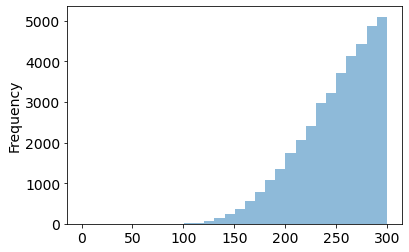

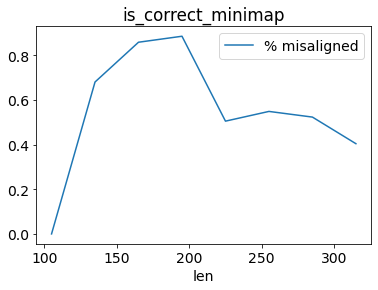

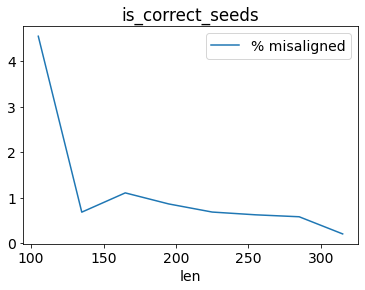

In [438]:
d='results/ecoli_head1000000_linear_long_300_ccs/'
check_minimap(d+'minimap2/aln.sam', d+'astar-seeds/alignments.tsv', d+'gt/sd_0001.maf')
#check_minimap('results/ecoli_head1000000_linear_long_300_ccs/minimap2/aln.sam', 'results/ecoli_head1000000_linear_long_300_ccs/long_300_ccs/sd_0001.maf')

In [344]:
check_minimap(minimap_sam_fn='results/ecoli_head1000000_linear_long_clr/minimap.sam', seeds_tsv_fn='results/ecoli_head1000000_linear_long_clr/astarix-seeds.tsv', gt_maf_fn='results/ecoli_head1000000_linear_long_clr/gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_clr/minimap.sam
results/ecoli_head1000000_linear_long_clr/gt/sd_0001.maf


FileNotFoundError: [Errno 2] No such file or directory: 'results/ecoli_head1000000_linear_long_clr/astarix-seeds.tsv'

In [337]:
check_minimap(minimap_sam_fn='results/ecoli_head1000000_linear_long_ccs/minimap.sam', seeds_tsv_fn='results/ecoli_head1000000_linear_long_ccs/astarix-seeds.tsv', gt_maf_fn='results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_ccs/minimap.sam
results/ecoli_head1000000_linear_long_ccs/gt/sd_0001.maf
Empty DataFrame
Columns: [ref, refsize, algo, operation, memory, len, read, spell, cost, starts, pushed, popped, repeat_rate, t(map), t(astar), unique_best, pushed+popped, explored_states]
Index: []


KeyboardInterrupt: 

In [345]:
d='results/ecoli_head1000000_linear_long_500_clr/'
check_minimap(d+'minimap2/aln.sam', d+'astar-seeds/alignments.tsv', d+'gt/sd_0001.maf')

results/ecoli_head1000000_linear_long_500_clr/minimap2/aln.sam
results/ecoli_head1000000_linear_long_500_clr/gt/sd_0001.maf


FileNotFoundError: [Errno 2] No such file or directory: 'results/ecoli_head1000000_linear_long_500_clr/astar-seeds/alignments.tsv'

In [195]:
## NOT USED
def compare_costs(df, col1='cost_seeds', col2='cost_minimap'):
    eq, seeds_better, minimap_better = 0, 0, 0
    
    for index, row in df.iterrows():
        #display(row)
        #print(index, row[col1], row[col2])
        if row[col1] == row[col2]:
            eq += 1
        elif row[col1] < row[col2]:
            seeds_better += 1
        elif row[col1] > row[col2]:
            #assert(False)
            #print('!!!')
            minimap_better += 1
        else:
            print("Mistake")
            assert(False)
    print('Checked ' + str(len(df)) + ' alignments:')
    print(col1 + ' better in:', seeds_better)
    print(col2 + ' minimap better in:', minimap_better)
    print('            Equal in:', eq)

In [192]:
compare_eq(df, 'minimap_loc', 'gt_loc')
#compare_costs(df, 'cost', 'minimap_str_cost')

Checked 100 alignments:
minimap_loc overlaps with gt_loc in: 99


ValueError: cannot switch from automatic field numbering to manual field specification

In [287]:
def draw_plot(df, colx, coly):
    ax = df.plot(colx, coly)


In [288]:
draw_plot(df, 'query_len', 'is_correct')

KeyError: 'query_len'